In [2]:
using CairoMakie
using NCDatasets
using Oceananigans
using Random, Statistics
using Printf
using TopographicHorizontalConvection: HorizontalConvectionSimulation


In [3]:
using Interpolations
using NaNStatistics

In [2]:
simulation = HorizontalConvectionSimulation(h₀_frac=0.6, output_writer=false, architecture=CPU())

Simulation of NonhydrostaticModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 6.250 ms
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 3.333 minutes
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 6 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   ├── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
│   ├── wizard => Callback of TimeStepWizard(cfl=0.5, max_Δt=Inf, min_Δt=0.0) on IterationInterval(50)
│   └── progress => Callback of (::TopographicHorizontalConvection.var"#progress#7") on IterationInterval(10)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [3]:
grid = simulation.model.grid.underlying_grid

2048×64×256 RectilinearGrid{Float64, Bounded, Periodic, Bounded} on CPU with 4×4×4 halo
├── Bounded  x ∈ [-4.0, 4.0]     regularly spaced with Δx=0.00390625
├── Periodic y ∈ [-0.125, 0.125) regularly spaced with Δy=0.00390625
└── Bounded  z ∈ [-1.0, 0.0]     regularly spaced with Δz=0.00390625

In [22]:
ds = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_buoyancy.nc"))
show(ds)
t = ds["time"][:]
b = ds["b"]
close(ds)

Dataset: /pub/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_buoyancy.nc
Group: /

Dimensions
   zC = 264
   zF = 265
   xC = 2056
   yF = 72
   xF = 2057
   yC = 72
   time = 21

Variables
  zC   (264)
    Datatype:    Float64 (Float64)
    Dimensions:  zC
    Attributes:
     units                = m
     longname             = Locations of the cell centers in the z-direction.

  zF   (265)
    Datatype:    Float64 (Float64)
    Dimensions:  zF
    Attributes:
     units                = m
     longname             = Locations of the cell faces in the z-direction.

  xC   (2056)
    Datatype:    Float64 (Float64)
    Dimensions:  xC
    Attributes:
     units                = m
     longname             = Locations of the cell centers in the x-direction.

  yF   (72)
    Datatype:    Float64 (Float64)
    Dimensions:  yF
    Attributes:
     units                = m
     longname             = Locations of the cell faces in the y-direction.

  xF   (2057)
    Datatype:    Fl

closed Dataset

In [7]:
ds2 = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_section_snapshots.nc"));
bₙ = ds2["b"][4+1:end-4, 1, 4+1:end-4, :]
close(ds2);

print(size(bₙ))

(2048, 256, 201)

In [21]:
@info "Making a neat movie of thc..."

#ds = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_buoyancy.nc"))
ds = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_section_snapshots.nc"))

times = ds["time"][:]

n = Observable(1)

x = ds["xC"][4+1:end-4]
#y = ds["yC"][4+1:end-3]
z = ds["zC"][4+1:end-4]

bₙ = @lift ds["b"][4+1:end-4, 1, 4+1:end-4, $n]

fig = Figure(size=(800,300))

kwargs=(xlabel = "x", 
        ylabel="z", 
        limits = ((-4,4), (-1,0)))

title = @lift @sprintf("nondimensional buoyancy at t =%.2f", times[$n])

ax_b = Axis(fig[1,1]; title=title, kwargs...)

b_lims = (-0.06, 0.06)

b = ds["b"][4+1:end-4, 1, 4+1:end-4, 15] # view without halos
wet = b.!=0. # This does not work for the initial timestep because our initial condition is that b==0 everywhere!
b[.!wet] .= NaN
wet_masked = Float64.(copy(wet))
wet_masked[wet] .= NaN

hm_b = heatmap!(ax_b, x, z, bₙ; colorrange = b_lims, colormap = :balance)
hm = heatmap!(ax_b, x, z, wet_masked[:,:], colormap = :algae)
Colorbar(fig[1,2], hm_b)

frames = 1:length(times)

record(fig, "../animations/thc_buoyancy_movie.mp4", frames, framerate = 8) do i
    n[] = i
end

close(ds)



[ Info: Making a neat movie of thc...


closed Dataset

In [22]:
#make a movie for HC NO HILLS

@info "Making a neat movie of hc..."

#ds = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_buoyancy.nc"))
ds = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h0.0_section_snapshots.nc"))

times = ds["time"][:]

n = Observable(1)

x = ds["xC"][4+1:end-4]
#y = ds["yC"][4+1:end-3]
z = ds["zC"][4+1:end-4]

bₙ = @lift ds["b"][4+1:end-4, 1, 4+1:end-4, $n]

fig = Figure(size=(800,300))

kwargs=(xlabel = "x", 
        ylabel="z", 
        limits = ((-4,4), (-1,0))
)

title = @lift @sprintf("nondimensional buoyancy at t =%.2f", times[$n])

ax_b = Axis(fig[1,1]; title=title, kwargs...)

b_lims = (-0.06, 0.06)

hm_b = heatmap!(ax_b, x, z, bₙ; colorrange = b_lims, colormap = :balance)
Colorbar(fig[1,2], hm_b)

frames = 1:length(times)

record(fig, "../animations/HC_buoyancy_movie3d.mp4", frames, framerate = 8) do i
    n[] = i
end

close(ds)

[ Info: Making a neat movie of hc...


closed Dataset

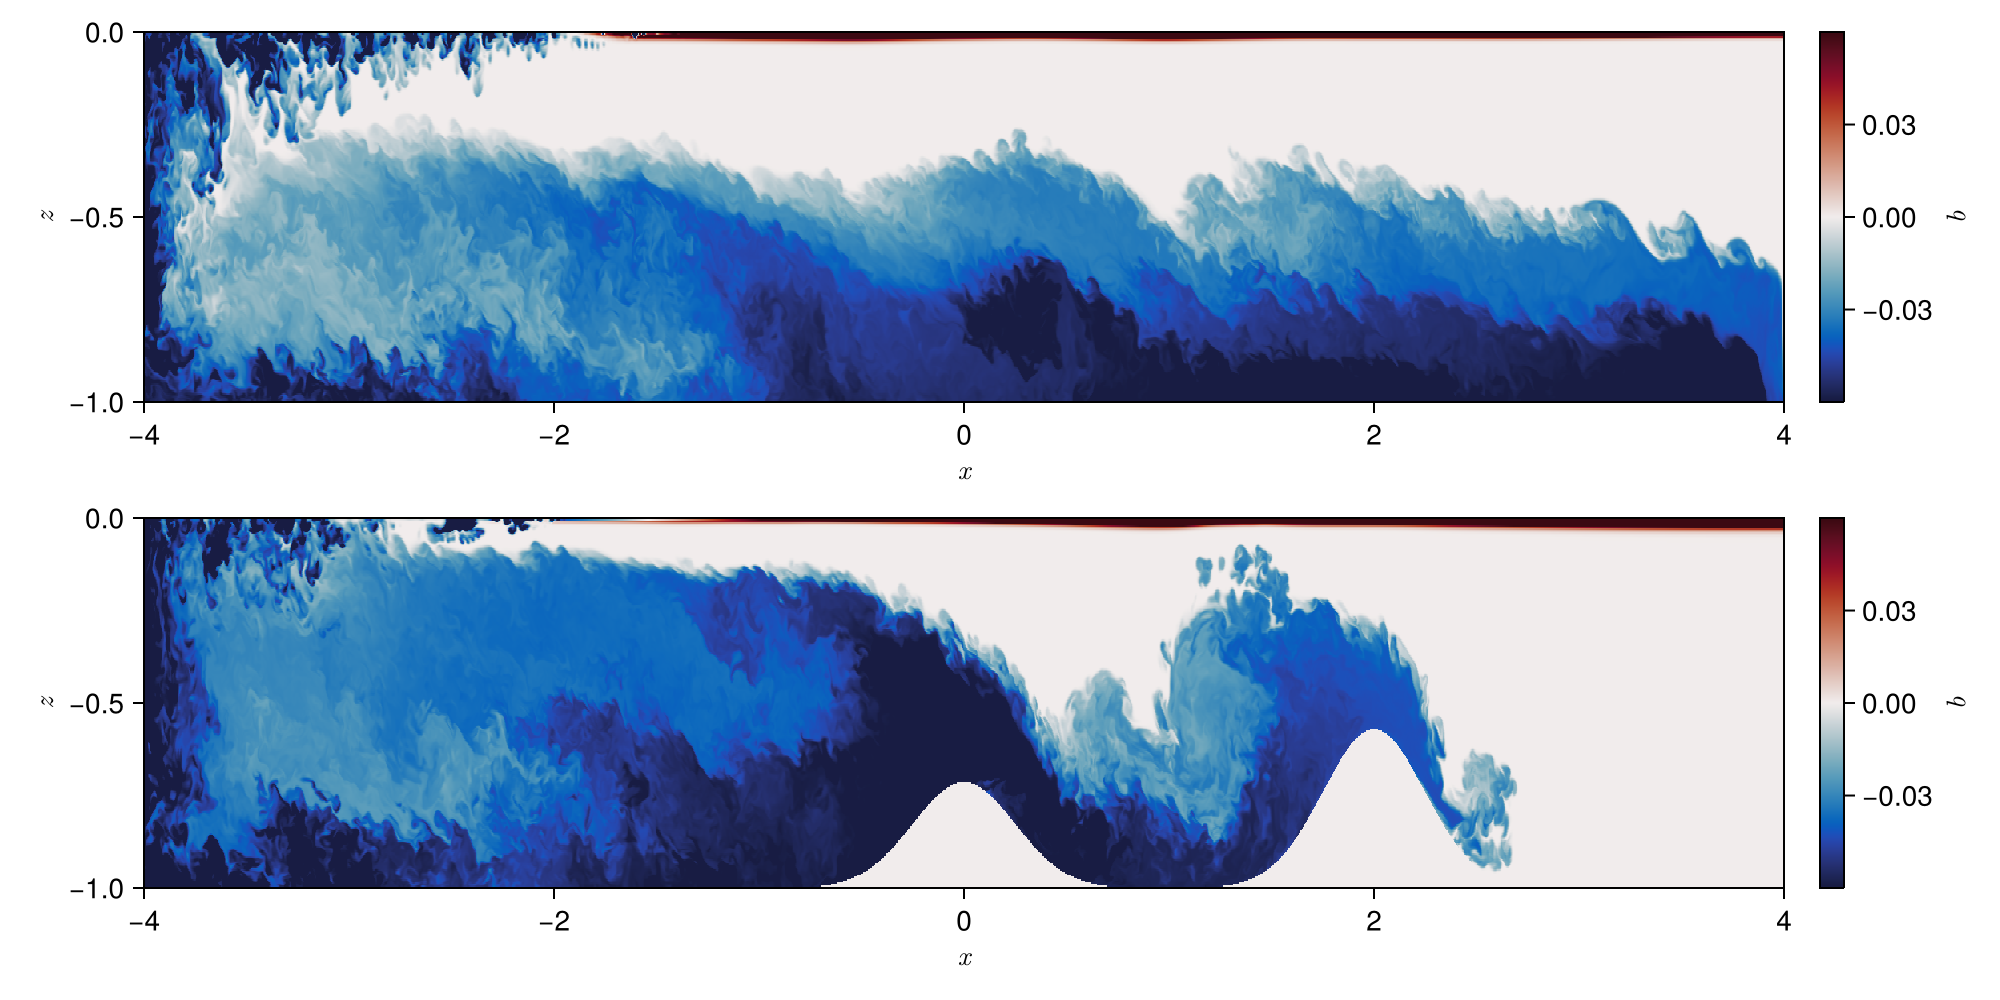

In [4]:
t = 10

f = Figure(size=(1000, 500))

for (i, h₀) in enumerate([0.0, 0.6])
    limits = ((grid.xᶠᵃᵃ[1], grid.xᶠᵃᵃ[grid.Nx+1]), ((grid.zᵃᵃᶠ[1], grid.zᵃᵃᶠ[grid.Nz+1])))
    ax = Axis(f[i,1], xlabel=L"$x$", ylabel=L"$z$", limits=limits)
    ds = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h", h₀, "_buoyancy.nc"));
    j = grid.Ny ÷ 2 # Section through center of domain
    hm = heatmap!(ax, ds["xF"][:], ds["zF"][:], ds["b"][:,j,:,t], colorrange = (-0.06, 0.06), colormap = :balance)
    Colorbar(f[i,2], hm, label=L"$b$");
    close(ds) # Make sure that we close the dataset!
end

f

In [5]:
save("../figures/thc_slice.png", f)

CairoMakie.Screen{IMAGE}


In [13]:
using Oceananigans: xspacings, yspacings, zspacings

In [10]:
function ComputeZstar(grid, B)
    x, y, z = nodes(b)
    
    Δx = xspacings(grid, Center())
    Δy = yspacings(grid, Center())
    Δz = zspacings(grid, Center())
    ΔA = Δx * Δy
    ΔV = ΔA * Δz
    
    zstar = zeros(size(B))
    for (i,x0) in enumerate(x)
        for (j,y0) in enumerate(y)
            for (k,z0) in enumerate(z)
                heavyside = B .< reshape(B[i,j,k,:], (1,1,1,size(B,4)))
                zstar[i,j,k,:] = (
                    sum(heavyside .* ΔV, dims=(1,2,3)) ./
                    sum(ones(size(B)[1:2]) .* ΔA)
                ) .+ grid.zᵃᵃᶠ[1]
            end
        end
    end
    
    return zstar
end

ComputeZstar (generic function with 1 method)

In [2]:
ds = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h0.6_buoyancy.nc"));
b = ds["b"]

b (2056 × 72 × 264 × 21)
  Datatype:    Float64 (Float64)
  Dimensions:  xC × yC × zC × time
  Attributes:
   units                = m/s²
   longname             = Buoyancy


In [3]:
t=10
j= 36
b[:, j, :, t]

2056×264 Matrix{Float64}:
 0.0  0.0  0.0   0.0         …   0.0        0.0      0.0  0.0  0.0
 0.0  0.0  0.0   0.0             0.0        0.0      0.0  0.0  0.0
 0.0  0.0  0.0   0.0             0.0        0.0      0.0  0.0  0.0
 0.0  0.0  0.0   0.0            -0.280103   0.0      0.0  0.0  0.0
 0.0  0.0  0.0  -0.088679       -0.280103  -1.7199   0.0  0.0  0.0
 0.0  0.0  0.0  -0.0863411   …  -0.262076  -1.73792  0.0  0.0  0.0
 0.0  0.0  0.0  -0.0853673      -0.226482  -1.7735   0.0  0.0  0.0
 0.0  0.0  0.0  -0.0831359      -0.212022  -1.78795  0.0  0.0  0.0
 0.0  0.0  0.0  -0.0806564      -0.202437  -1.79752  0.0  0.0  0.0
 0.0  0.0  0.0  -0.0785999      -0.192084  -1.80784  0.0  0.0  0.0
 0.0  0.0  0.0  -0.0777836   …  -0.18059   -1.81931  0.0  0.0  0.0
 0.0  0.0  0.0  -0.0776363      -0.165196  -1.83467  0.0  0.0  0.0
 0.0  0.0  0.0  -0.0775909      -0.153205  -1.84663  0.0  0.0  0.0
 ⋮                           ⋱              ⋮                  
 0.0  0.0  0.0  -4.99878e-7      0.8694

In [15]:
t = 10

f = Figure(size=(1000, 500))

for (i, h₀) in enumerate([0.0, 0.6])
    limits = ((grid.xᶠᵃᵃ[1], grid.xᶠᵃᵃ[grid.Nx+1]), ((grid.zᵃᵃᶠ[1], grid.zᵃᵃᶠ[grid.Nz+1])))
    ax = Axis(f[i,1], xlabel=L"$x$", ylabel=L"$z$", limits=limits)
    ds = NCDataset(string("/pub/hfdrake/code/HorizontalConvection/output/turbulent_h", h₀, "_buoyancy.nc"));
    j = grid.Ny ÷ 2 # Section through center of domain
    Zstar = ComputeZstar(grid, ds["b"])
    #hm = heatmap!(ax, ds["xF"][:], ds["zF"][:], ds["b"][:,j,:,t], colorrange = (-0.06, 0.06), colormap = :balance)
    #Colorbar(f[i,2], hm, label=L"$b$");
    close(ds) # Make sure that we close the dataset!
end

LoadError: MethodError: no method matching nodes(::CommonDataModel.CFVariable{Float64, 4, NCDatasets.Variable{Float64, 4, NCDataset{Nothing}}, NCDatasets.Attributes{NCDataset{Nothing}}, NamedTuple{(:fillvalue, :missing_values, :scale_factor, :add_offset, :calendar, :time_origin, :time_factor), Tuple{Nothing, Tuple{}, Vararg{Nothing, 5}}}})

[0mClosest candidates are:
[0m  nodes([91m::RectilinearGrid[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m; reshape, with_halos)
[0m[90m   @[39m [36mOceananigans[39m [90m~/.julia/packages/Oceananigans/0y15B/src/Grids/[39m[90m[4mrectilinear_grid.jl:417[24m[39m
[0m  nodes([91m::OrthogonalSphericalShellGrid[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m; reshape, with_halos)
[0m[90m   @[39m [36mOceananigans[39m [90m~/.julia/packages/Oceananigans/0y15B/src/Grids/[39m[90m[4morthogonal_spherical_shell_grid.jl:1080[24m[39m
[0m  nodes([91m::LatitudeLongitudeGrid[39m, [91m::Any[39m, [91m::Any[39m, [91m::Any[39m; reshape, with_halos)
[0m[90m   @[39m [36mOceananigans[39m [90m~/.julia/packages/Oceananigans/0y15B/src/Grids/[39m[90m[4mlatitude_longitude_grid.jl:576[24m[39m
[0m  ...
